In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import rand
from tqdm import tqdm
import time
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings('ignore')

#压缩包里面的三个文件prox,other_func,Algo需要加载
from prox import *
from other_func import *
from Algo import PGAC

# 1 模拟数据集

$256\times1024$的随机高斯测量矩阵A,并进行行正交化

In [2]:
import numpy as np
from scipy.linalg import orth
#Gaussian random measurement matrix
m = 256
n = 1024
Q = np.random.normal(0, 1, (m, n))
A = orth(Q.T).T
e,v = np.linalg.eig(A @ A.T)
print('最大特征值：',max(e).real)

最大特征值： 1.0000000000000058


In [3]:
shrinkage_list = [shrinkage_CaP1over2, shrinkage_CaP2over3, shrinkage_CaP1, shrinkage_l1over2, 
                  shrinkage_l2over3, shrinkage_l1, shrinkage_log, shrinkage_TL1, 
                  shrinkage_scad, shrinkage_mcp, shrinkage_PiE_soft]
#             CL1/2  CL2/3  CL1   L1/2   L2/3   L1    Log    TL1   SCAD   MCP   PiE 
a_list      = [2,    2,   1,    0,     0,     0,    1,     2,    3.7,   3.7,  2]
k_list = [10, 20, 31, 41, 51, 61, 72, 82, 92, 102, 113, 123] # 稀疏度
x_index = [i for i in range(n)]
maxiter = 500
mu = 1 

success_99 = np.zeros((len(k_list), len(shrinkage_list)))

for index_k, k in enumerate(k_list):
    for j in tqdm(range(100)):
        sigma = 0.001  # 噪声水平 σ = 0.1% = 0.001
        x_true = np.zeros((n, 1))
        nonzero_indices = np.random.choice(n, size=k, replace=False)
        x_true[nonzero_indices] = np.random.randn(k, 1)  # 非零值为高斯分布
        epsilon = sigma * np.random.randn(m, 1)
        b = A @ x_true + epsilon

        lamb = np.linalg.norm(x_true) / (np.sqrt(k) + 1)
        
        for i, shrinkage in enumerate(shrinkage_list):
            a = a_list[i]
            
            # 特殊算子的条件分支
            if i == 10:  # PiE
                temp = lamb / a_list[i] ** 2
                if temp <= 1:
                    shrinkage = shrinkage_PiE_soft
                else:
                    shrinkage = PiEProximalbyLambertWThreshold
            elif i == 6:  # Log
                if np.sqrt(lamb) <= a_list[i]:
                    shrinkage = shrinkage_log_soft
                else:
                    shrinkage = shrinkage_log_hard

            # 使用PGAC算法
            x_rec, iter_count = PGAC(A, b, mu, shrinkage, a, lamb, maxiter)
            if Error(x_rec, x_true) < 0.02:  
                success_99[index_k][i] += 0.01

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


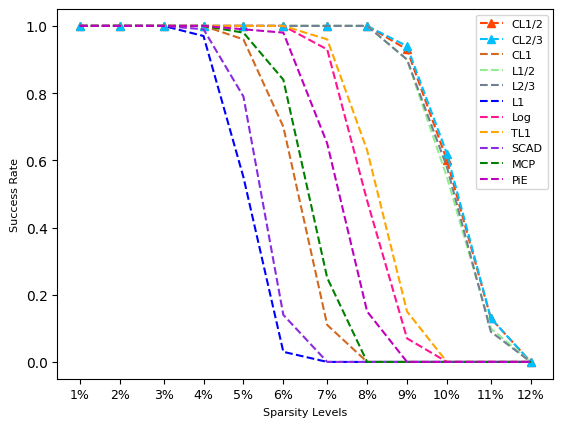

In [8]:
import pandas as pd
data = pd.read_excel("success_rate.xlsx", header=None)  # 无表头
success_99 = data.values.astype(float) 
color_list = ['orangered','deepskyblue','chocolate','lightgreen','slategrey','blue','deeppink',
              'orange','blueviolet','green','m']
label_list = ["CL1/2","CL2/3","CL1","L1/2","L2/3","L1","Log","TL1","SCAD","MCP","PiE"]
mark_list = ['^','^',None,None,None,None,None,None,None,None,None,None]
percent_labels = ['1%','2%','3%','4%','5%','6%','7%','8%','9%','10%','11%','12%']
plt.figure()
for i in range(11):
    plt.plot(k_list, success_99[:,i],label=label_list[i],color=f'{color_list[i]}', linestyle='--',marker =mark_list[i] )
plt.ylabel('Success Rate',fontsize =8)
plt.xlabel("Sparsity Levels",fontsize =8)
plt.xticks(k_list, percent_labels, fontsize=9)
plt.legend(fontsize =8)
plt.savefig(f'success_rate.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
import pandas as pd
df = pd.DataFrame(success_99, index=k_list, columns=label_list)
df.to_excel("success_rate.xlsx", engine="openpyxl")
print("Data has been saved to success_rate.xlsx")

Data has been saved to success_rate.xlsx
